In [1]:
import xarray as xr
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys

path = '/home/akazemi3/Desktop/MB_Lab_Project/'
sys.path.append(path)
from analysis.neural_data_regression.tools.regression import *

from tools.processing import *
from tools.loading import *

import pandas as pd
import seaborn as sns


In [2]:


def results_best_alpha(model, features_range,dataset,regions):

    
    root_path = '/data/atlas/model_scores'
    df_max_alphas = pd.read_csv(f'/home/akazemi3/Desktop/MB_Lab_Project/analysis/neural_data_regression/max_alphas_{dataset}_mp.csv')
    dict_max_alphas = df_max_alphas.set_index(['region','model']).to_dict()['alpha']

    
    df = pd.DataFrame()
    index = 0
    
    for f in features_range:
        
        features = 10**f 
        
        for region in regions:
            
            alpha = dict_max_alphas[(region, features)]
            regression_model = f'Ridge(alpha={alpha})'

            identifier = model + '_' + f'{features}' + '_' + dataset + '_' +  region +  '_' + regression_model 


            data = xr.open_dataset(os.path.join(root_path,f'{identifier}'))
            r_values = data.where(data.region == region,drop=True).r_value.values
            mean_r = np.mean(r_values)
            df_tmp =  pd.DataFrame({'mean_score':mean_r,
                                    'alpha':alpha,
                                    'model':f'{model}_{features}',
                                    'region':region},index=[index])    

            df = pd.concat([df,df_tmp])
            index += 1    
    
    return df


def results_best_alpha_cnn(models, dataset,regions):

    
    root_path = '/data/atlas/model_scores'
    df_max_alphas = pd.read_csv(f'/home/akazemi3/Desktop/MB_Lab_Project/analysis/neural_data_regression/max_alphas_cnns_{dataset}_mp.csv')
    dict_max_alphas = df_max_alphas.set_index(['region','model']).to_dict()['alpha']

    
    df = pd.DataFrame()
    index = 0
    
        
    for model in models:
        for region in regions:

                

            alpha = dict_max_alphas[(region, model)]
            regression_model = f'Ridge(alpha={alpha})'

            identifier = model + '_' + dataset + '_' + region + '_' + regression_model


            data = xr.open_dataset(os.path.join(root_path,f'{identifier}'))
            r_values = data.where(data.region == region,drop=True).r_value.values
            mean_r = np.mean(r_values)
            df_tmp =  pd.DataFrame({'mean_score':mean_r,
                                    'alpha':alpha,
                                    'model':f'{model}_{layer}',
                                    'region':region},index=[index])    

            df = pd.concat([df,df_tmp])
            index += 1    
    
    return df



def plot_best_alpha(df,df_cnn,palette_alpha,palette_region,linestyle,file_name):
        
    
    fig = plt.figure(figsize=(8,4),dpi=200)
    

    sns.scatterplot(x=df.features,y=df.mean_score,hue=df.alpha,palette=palette_alpha)
    sns.lineplot(x=df.features,y=df.mean_score,hue=df.region,palette=palette_region)
    
    if df_cnn is not None:
        i = 0
        for model in models:
            for region in regions:
            
                model_region = df_cnn[(df_cnn.model==model) & (df_cnn.region == region)].mean_score[i]
                plt.axhline(y=model_region,color=palette_region[region],linestyle=linestyle[model])
                i += 1

    # alexnet_u_V4 = df_cnn[(df_cnn.model=='alexnet_untrained_mp') & (df_cnn.region == 'V4')].mean_score[2]
    # plt.axhline(y=alexnet_u_V4,color='lightgray',linestyle='--')
    # alexnet_u_IT = df_cnn[(df_cnn.model=='alexnet_untrained_mp') & (df_cnn.region == 'IT')].mean_score[3]
    # plt.axhline(y=alexnet_u_IT,color='gray',linestyle='--') 
    
    
    #plt.legend([],[], frameon=False)
    plt.legend(loc='upper left',prop={'size': 8})
    plt.xlabel(xlabel='number of features')
    plt.xscale('log')
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    
    plt.savefig(f'/home/akazemi3/Desktop/MB_Lab_Project/results/parameter_study/{file_name}_{dataset}.png')

In [3]:
pd.read_csv(f'/home/akazemi3/Desktop/MB_Lab_Project/analysis/neural_data_regression/max_alphas_naturalscenes_zscored_processed_mp.csv')

,Unnamed: 0,region,model,alpha,mean_score
0,0,V1,10,1000,0.122448
1,1,V2,10,1000,0.096134
2,2,V3,10,10000,0.078130
3,3,V4,10,10000,0.065889
4,4,V1,100,10000,0.179434
5,5,V2,100,10000,0.149449
6,6,V3,100,10000,0.121468
7,7,V4,100,10000,0.099761
8,8,V1,1000,100000,0.229649
9,9,V2,1000,100000,0.198275


In [74]:
dataset = 'majajhong'
regions = ['V4','IT']


model = 'model_final_mp'
# dataset = 'naturalscenes_zscored_processed'
# regions = ['V1','V2','V3','V4']
df = results_best_alpha(model,dataset,regions)


models = ['alexnet_mp','alexnet_untrained_mp']
df_cnn = results_best_alpha_cnn(models,dataset,regions)


palette_region ={'V4':'lightgray','IT':'gray'}
palette_alpha = {1000:'lightgreen',10000:'darkgreen',100000:'black'}


file_name = 'best_alpha_all_models_majajhong'
plot_best_alpha(df,df_cnn,palette_alpha,palette_region,linestyle,file_name)

TypeError: results_best_alpha() missing 1 required positional argument: 'regions'

In [94]:
def results_best_alpha_cnn_layerwise(models, dataset,regions, layers):

    
    root_path = '/data/atlas/model_scores'
    df_max_alphas = pd.read_csv(f'/home/akazemi3/Desktop/MB_Lab_Project/analysis/neural_data_regression/max_alphas_cnns_{dataset}_mp_layerwise.csv')
    dict_max_alphas = df_max_alphas.set_index(['region','model']).to_dict()['alpha']

    
    df = pd.DataFrame()
    index = 0
    
        
    for model in models:
        for region in regions:

                

            for layer in layers:
                alpha = dict_max_alphas[(region, f'{model}_{layer}')]
                regression_model = f'Ridge(alpha={alpha})'

                identifier = model + '_' + dataset + '_' + layer + '_' + region + '_' + regression_model


                data = xr.open_dataset(os.path.join(root_path,f'{identifier}'))
                r_values = data.where(data.region == region,drop=True).r_value.values
                mean_r = np.mean(r_values)
                df_tmp =  pd.DataFrame({'mean_score':mean_r,
                                        'alpha':alpha,
                                        'model':f'{model}_{layer}',
                                        'region':region},index=[index])    

                df = pd.concat([df,df_tmp])
                index += 1    
    
    return df

def plot_best_alpha_layerwise(df,file_name,dataset):
        
    
    fig = plt.figure(figsize=(8,4),dpi=200)
    

    sns.scatterplot(x=df.region,y=df.mean_score,hue=df.model)
    
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    
    plt.savefig(f'/home/akazemi3/Desktop/MB_Lab_Project/results/parameter_study/{file_name}_{dataset}.png')

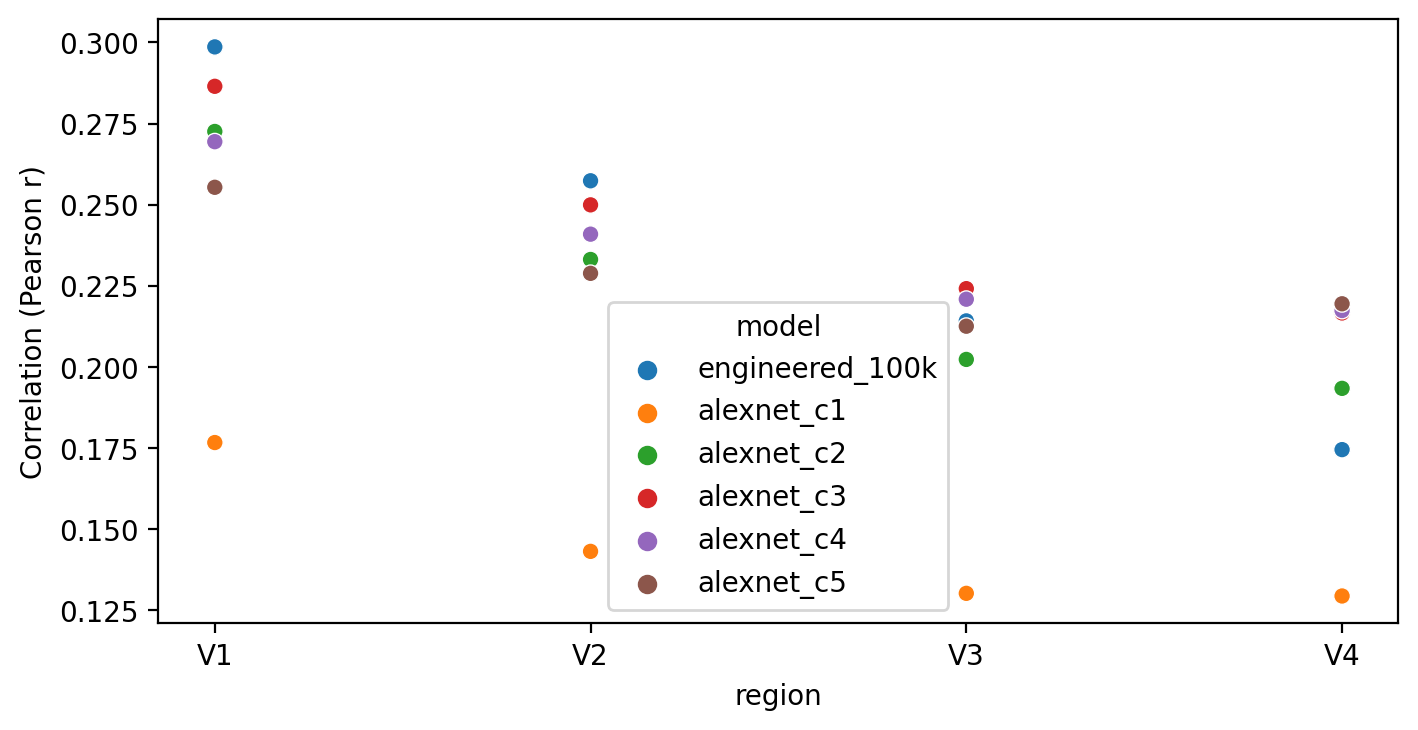

In [100]:
dataset = 'naturalscenes_zscored_processed'
regions = ['V1','V2','V3','V4']


models = f'model_final_mp'
features_range = (5,5)
df_model = results_best_alpha(models, features_range, dataset,regions)


cnn_models = ['alexnet_mp']
df_cnn = results_best_alpha_cnn_layerwise(cnn_models,dataset,regions,layers)

df = pd.concat([df_model,df_cnn])
df.model = df.model.map({'model_final_mp_100000':'engineered_100k',
                             'alexnet_mp_features.2':'alexnet_c1',
                               'alexnet_mp_features.5':'alexnet_c2',
                               'alexnet_mp_features.7':'alexnet_c3',
                               'alexnet_mp_features.9':'alexnet_c4',
                               'alexnet_mp_features.12':'alexnet_c5'})

file_name = f'best_alpha_all_models_naturalscenes_layerwise'
plot_best_alpha_layerwise(df,file_name,dataset)

In [2]:
import torch
w_l = []
f = torch.rand(4,1,3,3)
for i in range(3):
    w_l.append(f)
weight = torch.concat(w_l,dim=1)

In [3]:
weight

tensor([[[[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]],

         [[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]],

         [[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]]],


        [[[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]],

         [[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]],

         [[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]]],


        [[[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]],

         [[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]],

         [[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]]],


    

In [4]:
f.repeat(1,3,1,1)

tensor([[[[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]],

         [[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]],

         [[0.3424, 0.8166, 0.1610],
          [0.2336, 0.4770, 0.7632],
          [0.2686, 0.3523, 0.6039]]],


        [[[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]],

         [[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]],

         [[0.2949, 0.0908, 0.7984],
          [0.4387, 0.2490, 0.0424],
          [0.4838, 0.6721, 0.8108]]],


        [[[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]],

         [[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]],

         [[0.9694, 0.6324, 0.7725],
          [0.4826, 0.7952, 0.9961],
          [0.4976, 0.9551, 0.8350]]],


    

In [93]:
df_cnn

,mean_score,alpha,model,region
0,0.176703,10000,alexnet_c1,V1
1,0.272583,100000,alexnet_c2,V1
2,0.286500,1000000,alexnet_c3,V1
3,0.269428,100000,alexnet_c4,V1
4,0.255374,100000,alexnet_c5,V1
5,0.143166,10000,alexnet_c1,V2
6,0.233127,100000,alexnet_c2,V2
7,0.249959,1000000,alexnet_c3,V2
8,0.240928,100000,alexnet_c4,V2
9,0.228855,100000,alexnet_c5,V2
